In [2]:
from cif import cif
import math
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import statsmodels.api as sm

In [5]:
database = cif.createOneCountryDataFrameFromOECD('USA', 'MEI', frequency='Q', startDate='1990-Q1')
usa_df = database[0]

Requesting URL http://stats.oecd.org/SDMX-JSON/data/MEI/USA...Q/all
Data downloaded from https://stats.oecd.org/SDMX-JSON/data/MEI/USA...Q/all?startTime=1990-Q1&dimensionAtObservation=AllDimensions


In [6]:
##--- Création d'un dataframe pour USA ----

liste_var = ['NAEXKP01', 'LREMTTTT', 'LRACTTTT', 'LRUNTTTT', 'NAEXKP02', 'NAEXKP04', 'NAEXKP06']

headers = ['PIB', 'Emplois', 'Actifs', 'Chomage', 'Conso', 'Formation', 'Exports']

d = {col:var_df for col, var_df in zip(headers, [usa_df['{0}'.format(var)]["STSA"] for var in liste_var])}
usa_bon_df = pd.DataFrame(d)

In [7]:
usa_bon_df

,PIB,Emplois,Actifs,Chomage,Conso,Formation,Exports
time,,,,,,,
1990-Q1,9358.289,63.200000,66.733333,5.300000,5998.058,1695.374,682.300
1990-Q2,9392.251,63.000000,66.533333,5.333333,6016.329,1668.437,690.785
1990-Q3,9398.499,62.666667,66.466667,5.700000,6040.163,1659.143,696.014
1990-Q4,9312.937,62.333333,66.400000,6.133333,5994.212,1628.395,702.143
1991-Q1,9269.367,61.900000,66.233333,6.600000,5971.672,1587.408,706.434
...,...,...,...,...,...,...,...
2019-Q4,19253.959,60.966667,63.233333,3.600000,13353.687,4075.404,2557.846
2020-Q1,19010.848,60.700000,63.100000,3.800000,13118.406,4075.494,2495.099
2020-Q2,17302.511,52.900000,60.800000,13.066667,11860.250,3795.484,1927.417


In [8]:
## Créons d'abord une colonne time qui donne la date sous le format AAAA-MM-JJ

qs = usa_bon_df.index.str.replace(r'(Q\d) (\d+)', r'\2-\1')
usa_bon_df['date'] = pd.PeriodIndex(qs, freq='Q').to_timestamp()
usa_bon_df = usa_bon_df.reindex(index=usa_bon_df['date'])
#usa_bon_df = usa_bon_df.drop("date", axis=1)
usa_bon_df

,PIB,Emplois,Actifs,Chomage,Conso,Formation,Exports,date
date,,,,,,,,
1990-01-01,9358.289,63.200000,66.733333,5.300000,5998.058,1695.374,682.300,1990-01-01
1990-04-01,9392.251,63.000000,66.533333,5.333333,6016.329,1668.437,690.785,1990-04-01
1990-07-01,9398.499,62.666667,66.466667,5.700000,6040.163,1659.143,696.014,1990-07-01
1990-10-01,9312.937,62.333333,66.400000,6.133333,5994.212,1628.395,702.143,1990-10-01
1991-01-01,9269.367,61.900000,66.233333,6.600000,5971.672,1587.408,706.434,1991-01-01
...,...,...,...,...,...,...,...,...
2019-10-01,19253.959,60.966667,63.233333,3.600000,13353.687,4075.404,2557.846,2019-10-01
2020-01-01,19010.848,60.700000,63.100000,3.800000,13118.406,4075.494,2495.099,2020-01-01
2020-04-01,17302.511,52.900000,60.800000,13.066667,11860.250,3795.484,1927.417,2020-04-01


## Statistiques descriptives

In [9]:
#On calcule des moyennes mobiles du PIB sur toute la période pour essayer d'en extraire la tendance : 

usa_bon_df['Moyenne mobile PIB'] = usa_bon_df[['PIB','date']].rolling(window = 16,center = True,on = 'date').sum().drop('date', axis = 1)/16

#on calcule le résidu du pib : 

usa_bon_df['résidu PIB'] = usa_bon_df ['PIB'] - usa_bon_df['Moyenne mobile PIB'] 

C:\Users\SURFACE\Anaconda3\lib\site-packages\pandas\plotting\_matplotlib\converter.py:103: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


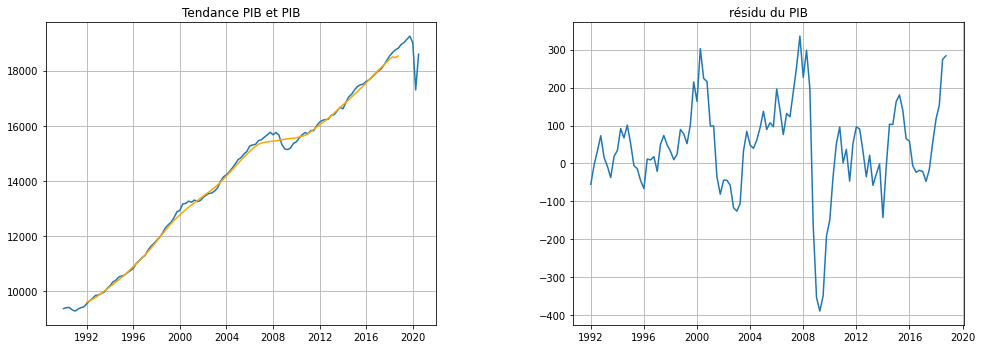

In [10]:
#On plot ces deux séries qu'on a obtenu : 
plt.figure(figsize=(15,5))

#Tendance du PIB :
plt.subplot(121)
plt.plot(usa_bon_df['date'].to_numpy(),usa_bon_df['PIB'].to_numpy())
plt.plot(usa_bon_df['date'].to_numpy(),usa_bon_df['Moyenne mobile PIB'], color = 'orange')
plt.title('Tendance PIB et PIB')
plt.grid(True)

#Résidus : 
plt.subplot(122)
plt.plot(usa_bon_df['date'].to_numpy(),usa_bon_df['résidu PIB'].to_numpy())
plt.title('résidu du PIB')
plt.grid(True)

plt.subplots_adjust(top=0.92, bottom=0.08, left=0.10, right=0.95, hspace=0.1,
                    wspace=0.35)

plt.show()

In [11]:
#On va calculer la moyenne mobile sur deux ans des séries du chomage et des exports : 
usa_bon_df['Moyenne mobile chomage'] = usa_bon_df[['Chomage','date']].rolling(window = 16,center = True,on = 'date').sum().drop('date', axis = 1)/16

usa_bon_df['Moyenne mobile exports'] = usa_bon_df[['Exports','date']].rolling(window = 16,center = True,on = 'date').sum().drop('date', axis = 1)/16

#Note : c'est normal que l'on ai pas les 8 premières et dernières valeurs puisque c'est une moyenne glissante centrée

#on calcule aussi les résidus sur les deux séries :

usa_bon_df['résidu exports'] = usa_bon_df ['Exports'] - usa_bon_df['Moyenne mobile exports'] 
usa_bon_df['résidu chomage'] = usa_bon_df ['Chomage'] - usa_bon_df['Moyenne mobile chomage'] 


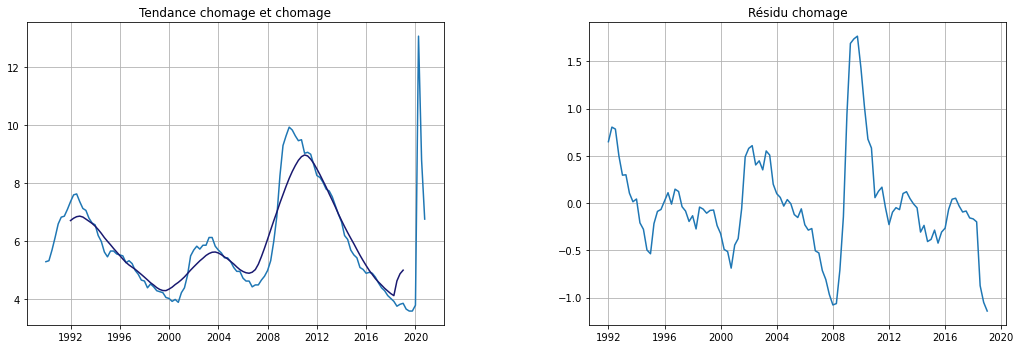

In [12]:
# On plot les séries du chômage :
plt.figure(figsize=(16,5))

# Chomage et tendance
plt.subplot(121)
plt.plot(usa_bon_df['date'].to_numpy(),usa_bon_df['Chomage'].to_numpy())
plt.plot(usa_bon_df['date'].to_numpy(),usa_bon_df['Moyenne mobile chomage'], color = 'midnightblue')
plt.title('Tendance chomage et chomage')
plt.grid(True)


# résidus
plt.subplot(122)
plt.plot(usa_bon_df['date'].to_numpy(),usa_bon_df['résidu chomage'].to_numpy())
plt.title('Résidu chomage')
plt.grid(True)

plt.subplots_adjust(top=0.92, bottom=0.08, left=0.10, right=0.95, hspace=0.1,
                    wspace=0.35)

plt.show()

On peut voir ici que le chomage est extrêment variable sur toute la période et qu'aucune tendance ne semble vraiment se dégager (même la courbe des moyennes mobiles est très variables).

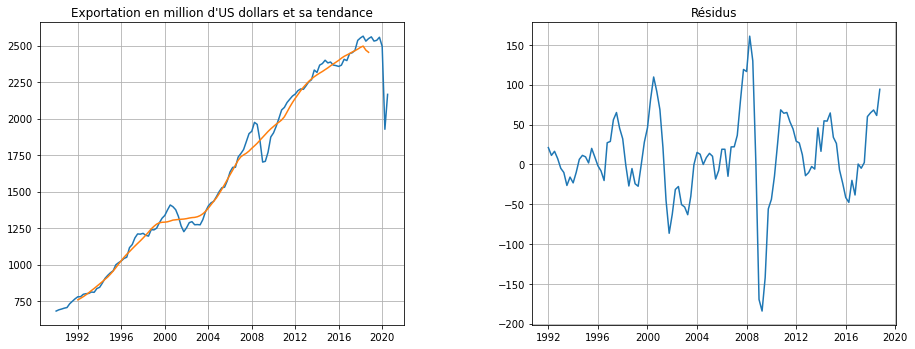

In [13]:
#On plot la série des exports : 
plt.figure(figsize=(14,5))
# exports
plt.subplot(121)
plt.plot(usa_bon_df['date'].to_numpy(),usa_bon_df['Exports'].to_numpy())
plt.plot(usa_bon_df['date'].to_numpy(),usa_bon_df['Moyenne mobile exports'].to_numpy())
plt.title('Exportation en million d\'US dollars et sa tendance')
plt.grid(True)

# résidus
plt.subplot(122)
plt.plot(usa_bon_df['date'].to_numpy(),usa_bon_df['résidu exports'].to_numpy())
plt.title('Résidus')
plt.grid(True)

plt.subplots_adjust(top=0.92, bottom=0.08, left=0.10, right=0.95, hspace=0.1,
                    wspace=0.35)

plt.show()

On peut voir ici qu'il semble y avoir une tendance à la hausse des exportations, bien que celle ci soit bruité par les différents chocs sur l'économie : en effet on peut voir que la crise de 2008 n'a pas été sans effet sur celles-ci, et de même dans les années 2000 et 2001 les attentats du 11 novembre et l'éclatement de la bulle internet ont probablement freiné la croissance des exportations.

### Généralisation à d'autres pays de l'OCDE :

In [10]:
headers = ['PIB', 'Emplois', 'Actifs', 'Chomage', 'Conso', 'Formation', 'Exports']
ocde_df = pd.DataFrame(columns = headers.append('Pays'))

liste_var = ['NAEXKP01', 'LREMTTTT', 'LRACTTTT', 'LRUNTTTT', 'NAEXKP02', 'NAEXKP04', 'NAEXKP06']



pays_ocde = {"Germany" :'DEU',"Australie" :'AUS',"Austria":'AUT',"Belgium":'BEL',"Canada":'CAN',"Denmark":'DNK',"Spain":'ESP',"Finland":'FIN',"France":'FRA',"Greece":'GRC',"Ireland":'IRL',"Italia":'ITA',
             "Japan":'JPN',"Luxembourg":'LUX',"Norway":'NOR',"New-Zealand":'NZL',"Netherlands":'NLD',"Portugal":'PRT',"Great-Britain":'GBR',"Sweden":'SWE',"Switzerland":'CHE',"Turkey":'TUR',"United-States":'USA'}

for country in pays_OCDE.keys():
    # On importe de l'OCDE les données :
    country_df = cif.createOneCountryDataFrameFromOECD('{0}'.format(pays_ocde[country]),
                                                       'MEI', frequency='Q',
                                                       startDate='1990-Q1')[0]
    
    #On récupère les colonnes:
    d = {col:var_df for col, var_df in zip(headers, [country_df['{0}'.format(var)]["STSA"] for var in liste_var])}
    country_bon_df = pd.DataFrame(d)
    
    qs = country_bon_df.index.str.replace(r'(Q\d) (\d+)', r'\2-\1')
    country_bon_df = country_bon_df.T
    country_bon_df.columns = qs
    #country_bon_df['date'] = pd.PeriodIndex(qs, freq='Q').to_timestamp()
    #country_bon_df = country_bon_df.reindex(index=country_bon_df['date'])
    #country_bon_df = country_bon_df.drop("date", axis=1)
    country_bon_df['Pays'] = country
    ocde_df = pd.concat([ocde_df, country_bon_df], axis=0)
    



Requesting URL http://stats.oecd.org/SDMX-JSON/data/MEI/DEU...Q/all
Data downloaded from https://stats.oecd.org/SDMX-JSON/data/MEI/DEU...Q/all?startTime=1990-Q1&dimensionAtObservation=AllDimensions
Requesting URL http://stats.oecd.org/SDMX-JSON/data/MEI/AUS...Q/all
Data downloaded from https://stats.oecd.org/SDMX-JSON/data/MEI/AUS...Q/all?startTime=1990-Q1&dimensionAtObservation=AllDimensions
Requesting URL http://stats.oecd.org/SDMX-JSON/data/MEI/AUT...Q/all
Data downloaded from https://stats.oecd.org/SDMX-JSON/data/MEI/AUT...Q/all?startTime=1990-Q1&dimensionAtObservation=AllDimensions


KeyboardInterrupt: 

In [122]:
compare_df = ocde_df.loc['PIB'].reset_index(drop = True).set_index('Pays').T
compare_df.head()

Pays,DEU,AUS,AUT,BEL,CAN,DNK,ESP,FIN,FRA,GRC,...,LUX,NOR,NZL,NLD,PRT,GBR,SWE,CHE,TUR,USA
1990-Q1,NaN,206.890,NaN,NaN,275.46825,NaN,NaN,32.137,368.384,NaN,...,NaN,460.822,27.703,NaN,NaN,305.893,NaN,113.317453,NaN,9358.289
1990-Q2,NaN,207.173,NaN,NaN,274.32750,NaN,NaN,31.695,369.679,NaN,...,NaN,465.800,27.590,NaN,NaN,307.471,NaN,113.978585,NaN,9392.251
1990-Q3,NaN,205.931,NaN,NaN,272.38650,NaN,NaN,31.023,371.314,NaN,...,NaN,461.219,27.594,NaN,NaN,304.257,NaN,113.561986,NaN,9398.499
1990-Q4,NaN,207.139,NaN,NaN,269.95900,NaN,NaN,30.844,372.255,NaN,...,NaN,473.569,28.140,NaN,NaN,303.210,NaN,113.071187,NaN,9312.937
1991-Q1,557.3467,204.453,NaN,NaN,266.10650,NaN,NaN,30.224,372.104,NaN,...,NaN,477.587,27.214,NaN,NaN,302.325,NaN,113.236241,NaN,9269.367


### Comparaison avec d'autres pays de l'OCDE :

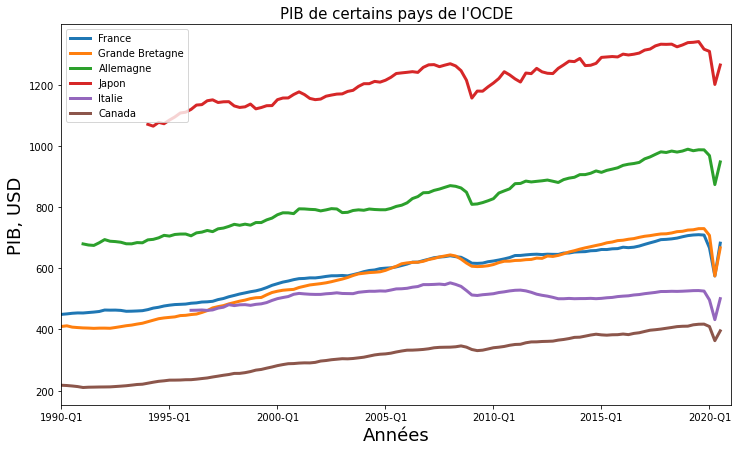

In [123]:
##-------Création du df----------
'''compare_df = pd.DataFrame(usa_bon_df['PIB'])
compare_df = compare_df.rename(columns={'PIB':'USA'})

for country in pays_OCDE:
        
    
    country_df = cif.createOneCountryDataFrameFromOECD('{0}'.format(country),
                                                       'MEI', frequency='Q',
                                                       startDate='1990-Q1')[0]
    
    
    d = {col:var_df for col, var_df in zip(headers, [country_df['{0}'.format(var)]["STSA"] for var in liste_var])}
    country_bon_df = pd.DataFrame(d)
    
    qs = country_bon_df.index.str.replace(r'(Q\d) (\d+)', r'\2-\1')
    country_bon_df['date'] = pd.PeriodIndex(qs, freq='Q').to_timestamp()
    country_bon_df = country_bon_df.reindex(index=country_bon_df['date'])
    country_bon_df = country_bon_df.drop("date", axis=1)
    
    compare_df = pd.concat([compare_df, country_bon_df.rename(columns={'PIB':'{0}'.format(country)})['{0}'.format(country)]], axis=1)
'''
compare_df = ocde_df.loc['PIB'].reset_index(drop = True).set_index('Pays').T

##`--- Conversion des monnais nationales en dollars
compare_df['JPN'] = compare_df['JPN']*0.0096
compare_df['FRA'] = compare_df['FRA']*1.22
compare_df['DEU'] = compare_df['DEU']*1.22
compare_df['ITA'] = compare_df['ITA']*1.22
compare_df['BEL'] = compare_df['BEL']*1.22
compare_df['CAN'] = compare_df['CAN']*0.79
compare_df['GBR'] = compare_df['GBR']*1.34
compare_df['AUS'] = compare_df['AUS']*0.76

## ------ Visualisation ---------

fig = plt.figure(figsize=(12, 7))
ax = fig.add_subplot(111)

compare_df['FRA'].plot(label='France', linewidth=3)
compare_df['GBR'].plot(label="Grande Bretagne", linewidth=3)
compare_df['DEU'].plot(label='Allemagne', linewidth=3)
compare_df['JPN'].plot(label='Japon', linewidth=3)
compare_df['ITA'].plot(label='Italie', linewidth=3)
compare_df['CAN'].plot(label='Canada', linewidth=3)
ax.set_xlabel('Années', fontsize=18)
ax.set_ylabel('PIB, USD', fontsize=18)
plt.title("PIB de certains pays de l'OCDE", fontsize=15)
plt.legend(loc='best')

plt.show()

## Test de stationnairité sur le PIB américain

In [11]:
#Préparation pour test de stationnarité 
PIB_temp = usa_bon_df['PIB']

In [12]:
# SARIMAX
mdl = sm.tsa.statespace.SARIMAX(PIB_temp,order=(0, 0, 0),seasonal_order=(2, 2, 1, 7),enforce_stationarity=True,enforce_invertibility=True)
res = mdl.fit()

C:\Users\Asus\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency QS-OCT will be used.
  warnings.warn('No frequency information was'
C:\Users\Asus\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency QS-OCT will be used.
  warnings.warn('No frequency information was'


C:\Users\Asus\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency QS-OCT will be used.
  warnings.warn('No frequency information was'
C:\Users\Asus\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency QS-OCT will be used.
  warnings.warn('No frequency information was'


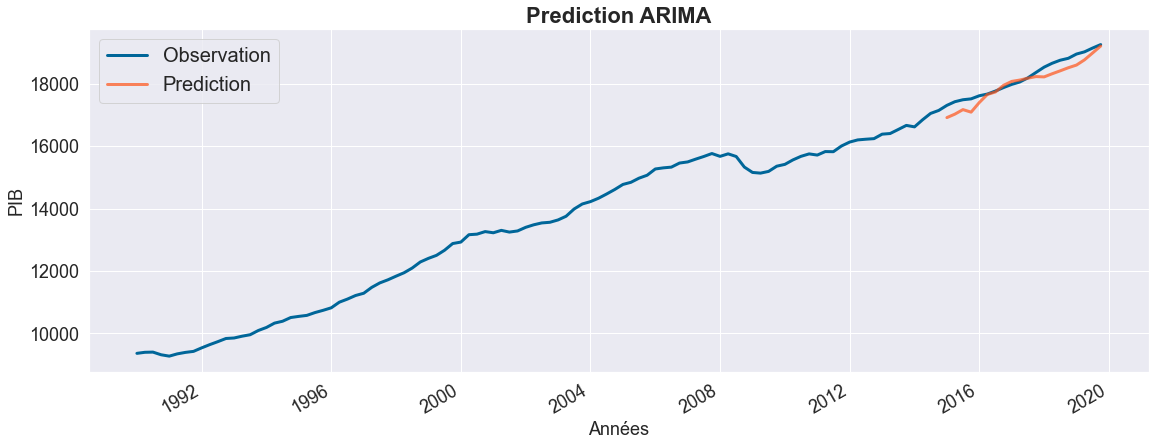

In [33]:
# fit model to data
res = sm.tsa.statespace.SARIMAX(PIB_temp,
                                order=(0, 0, 0),
                                seasonal_order=(2, 2, 1, 7),
                                enforce_stationarity=True,
                                enforce_invertibility=True).fit()

# in-sample-prediction and confidence bounds
pred = res.get_prediction(start = "2015-01-01", 
                          end = "2019-10-01",
                          dynamic = False, 
                          full_results=True)


 # plot in-sample-prediction
fig = plt.figure(figsize=(19, 7))
ax = fig.add_subplot(111)
ax.plot(PIB_temp[0:120],color='#006699',linewidth = 3, label='Observation');
pred.predicted_mean.plot(ax=ax,linewidth = 3, linestyle='-', label='Prediction', alpha=.7, color='#ff5318', fontsize=18);
ax.set_xlabel('Années', fontsize=18)
ax.set_ylabel('PIB', fontsize=18)
plt.legend(loc='upper left', prop={'size': 20})
plt.title('Prediction ARIMA', fontsize=22, fontweight="bold")
plt.show()

rmse = math.sqrt(((pred.predicted_mean.values.reshape(-1, 1) - PIB_temp[100:120].values.reshape(-1,1))**2).mean())

In [34]:
print(res.summary())
print(print('rmse = '+ str(rmse)))

                                 SARIMAX Results                                 
Dep. Variable:                       PIB   No. Observations:                  123
Model:             SARIMAX(2, 2, [1], 7)   Log Likelihood                -815.285
Date:                   Mon, 14 Dec 2020   AIC                           1638.570
Time:                           15:05:00   BIC                           1649.335
Sample:                       01-01-1990   HQIC                          1642.935
                            - 07-01-2020                                         
Covariance Type:                     opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.S.L7        0.1888      0.204      0.927      0.354      -0.210       0.588
ar.S.L14      -0.0895      0.155     -0.578      0.563      -0.393       0.214
ma.S.L7       -0.7904      0